# Augmenting a dataset for object detection in YOLO

In this notebook, we illustrate how CLODSA can be employed to augment a dataset of images devoted to object detection using the [YOLO format](https://pjreddie.com/darknet/yolo/). In particular, we use a subset of the [Pascal VOC dataset](http://host.robots.ox.ac.uk/pascal/VOC/). We will use 20 images from that dataset. Such a subset can be downloaded by executing the following command. 

In [ ]:
!wget https://www.dropbox.com/s/7j00clf7tmn1ilm/PascalVOCYOLO.zip?dl=0 -O PascalVOCYOLO.zip
!unzip PascalVOCYOLO.zip

We can check the amount of images in each one of the folders.

In [ ]:
print("Number of images in the folder")
!ls -1 PascalVOCYOLO/*.jpg | wc -l

Number of images in the folder
20


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import shutil

In [ ]:


source_folder = '/content/drive/MyDrive/CS331_Nhóm/Datasets_Recog/Image/Train/'
source_folder_2 = '/content/drive/MyDrive/CS331_Nhóm/Datasets_Recog/Label/Train/'
destination_folder = '/content/drive/MyDrive/CS331_Nhóm/test/input/'

# fetch all files
for file_name in os.listdir(source_folder):
    # construct full file path
    source = source_folder + file_name
    destination = destination_folder + file_name
    # copy only files
    if os.path.isfile(source):
        shutil.copy(source, destination)
        print('copied', file_name)
        
# fetch all files
for file_name in os.listdir(source_folder_2):
    # construct full file path
    source = source_folder_2 + file_name
    destination = destination_folder + file_name
    # copy only files
    if os.path.isfile(source):
        shutil.copy(source, destination)
        print('copied', file_name)

In [4]:
len(os.listdir('/content/drive/MyDrive/CS331_Nhóm/test/input'))

608

## Augmentation techniques

In this notebook, we will use the following augmentation techniques:
- Vertical, horizontal, and vertical-horizontal flips.
- 180º Rotation.
- Average blurring.
- Raise the hue value. 

## Installing the necessary libraries

In case that CLODSA is not installed in your system, the first task consists in installing it using ``pip``.

In [5]:
!pip install clodsa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.7 MB 13.1 MB/s 
     |████████████████████████████████| 276 kB 66.5 MB/s 
  Created wheel for clodsa: filename=clodsa-1.2.47-py2.py3-none-any.whl size=74310 sha256=b8dbfe3c438cdbfbb8fe39d8a891edbaa6986f8f5129da1867fa539dda558145
  Stored in directory: /root/.cache/pip/wheels/05/ff/0a/0e6e14c2a68d6869a010e979b8fd9d669aaeaa2d8b29de394f
  Created wheel for commentjson: filename=commentjson-0.9.0-py3-none-any.whl size=12092 sha256=f6065a04c086979aeabccd2206b71f6dffaeb1c378a778a98295554819068a39
  Stored in directory: /root/.cache/pip/wheels/eb/bb/07/25a7f0718ee3fe137384011b8e56070f91cf950ee6047c287f
  Created wheel for lark-parser: filename=lark_parser-0.7.8-py2.py3-none-any.whl size=62527 sha256=b18149724ec40902ba9a12b9fe917f9177b75fccd3a1c703ede4025688280861
  Stored in directory: /root/.cache/pip/wheels/92/e3/af/1dc0fdca93232d700ac176af6554cf22b85f

## Loading the necessary libraries

The first step in the pipeline consists in loading the necessary libraries to apply the data augmentation techniques in CLODSA. We also load some libraries to show the results.

In [6]:
from matplotlib import pyplot as plt
from clodsa.augmentors.augmentorFactory import createAugmentor
from clodsa.transformers.transformerFactory import transformerGenerator
from clodsa.techniques.techniqueFactory import createTechnique
import xml.etree.ElementTree as ET
import cv2
%matplotlib inline

## Creating the augmentor object

As explained in the documentation of CLODSA, we need to specify some parameters for the augmentation process, and use them to create an augmentor object.  

_The kind of problem_. In this case, we are working in a detection problem

In [7]:
PROBLEM = "detection"

_The annotation mode_. We use the YOLO format. 

In [8]:
ANNOTATION_MODE = "yolo"

_The input path_. The input path containing the images. 

In [9]:
INPUT_PATH = '/content/drive/MyDrive/CS331_Nhóm/test/input/'

_The generation mode_. In this case, linear, that is, all the augmentation techniques are applied to all the images of the original dataset. 

In [10]:
GENERATION_MODE = "linear"

_The output mode_. The generated images will be stored in a new folder called augmented_images.  

In [11]:
OUTPUT_MODE = "yolo"
OUTPUT_PATH= "augmented_images_yolo"

Using the above information, we can create our augmentor object. 

In [12]:
augmentor = createAugmentor(PROBLEM,ANNOTATION_MODE,OUTPUT_MODE,GENERATION_MODE,INPUT_PATH,{"outputPath":OUTPUT_PATH})

## Adding the augmentation techniques

Now, we define the techniques that will be applied in our augmentation process and add them to our augmentor object. To illustrate the transformations, we will use the following image of the dataset. 



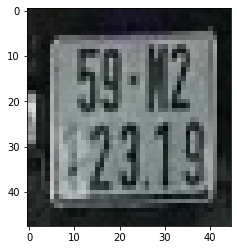

In [13]:
img = cv2.imread("/content/drive/MyDrive/CS331_Nhóm/test/input/frame0.jpg")
# changing to the BGR format of OpenCV to RGB format for matplotlib
plt.imshow(img[:,:,::-1])

Just for showing the results of applying data augmentation in an object detection problem, we define a function to read the annotations and another one to show them. This funcionality is not necessary when using CLODSA since it is already implemented in there. 

In [14]:
def boxesFromYOLO(imagePath,labelPath):
    image = cv2.imread(imagePath)
    (hI, wI) = image.shape[:2]
    lines = [line.rstrip('\n') for line in open(labelPath)]
    #if(len(objects)<1):
    #    raise Exception("The xml should contain at least one object")
    boxes = []
    if lines != ['']:
        for line in lines:
            components = line.split(" ")
            category = components[0]
            x  = int(float(components[1])*wI - float(components[3])*wI/2)
            y = int(float(components[2])*hI - float(components[4])*hI/2)
            h = int(float(components[4])*hI)
            w = int(float(components[3])*wI)
            boxes.append((category, (x, y, w, h)))
    return (image,boxes)

In [25]:
categoriesColors = {11: (255,0,0),14:(0,0,255)}

def showBoxes(image,boxes, name = ' ' , save = False):
    cloneImg = image.copy()
    for box in boxes:
        if(len(box)==2):
            (category, (x, y, w, h))=box
        else:
            (category, (x, y, w, h),_)=box
        if int(category) in categoriesColors.keys():
            cv2.rectangle(cloneImg,(x,y),(x+w,y+h),(255,0,0),0)
        else:
            cv2.rectangle(cloneImg,(x,y),(x+w,y+h),(0,255,0),0)
    plt.imshow(cloneImg[:,:,::-1])
    if (save):
      plt.imsave('/content/drive/MyDrive/CS331_Nhóm/test/output/{}.jpg'.format(name), cloneImg[:,:,::-1])
    

Now, we show the annotation of the image.

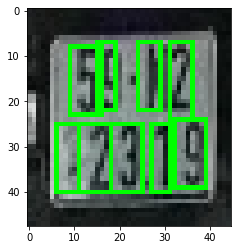

In [26]:
img,boxes = boxesFromYOLO('/content/drive/MyDrive/CS331_Nhóm/test/input/frame0.jpg',"/content/drive/MyDrive/CS331_Nhóm/test/input/frame0.txt")
showBoxes(img,boxes)

First of all, we must define a transformer generator.

In [27]:
transformer = transformerGenerator(PROBLEM)

#### Vertical flip

In [30]:
vFlip = createTechnique("flip",{"flip":0})
augmentor.addTransformer(transformer(vFlip))

Showing the result of applying the transformation.

[('5', (9, 24, 8, 16), 1.0), ('9', (15, 25, 5, 16), 1.0), ('20', (24, 25, 6, 16), 1.0), ('2', (31, 23, 6, 18), 1.0), ('1', (6, 7, 6, 16), 1.0), ('2', (11, 7, 8, 16), 1.0), ('3', (18, 7, 8, 16), 1.0), ('1', (27, 7, 5, 16), 1.0), ('9', (32, 8, 8, 16), 1.0)]


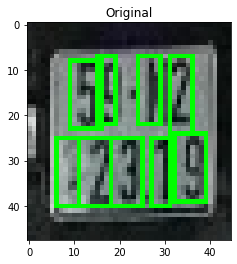

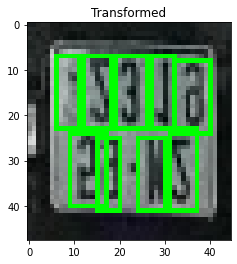

In [31]:
plt.figure()
plt.title("Original")
showBoxes(img,boxes)
vFlipGenerator = transformer(vFlip)
vFlipImg,vFlipBoxes = vFlipGenerator.transform(img,boxes)
plt.figure()
print(vFlipBoxes)
plt.title("Transformed")
showBoxes(vFlipImg,vFlipBoxes)

#### Horizontal flip

In [ ]:
hFlip = createTechnique("flip",{"flip":1})
augmentor.addTransformer(transformer(hFlip))

Showing the result of applying the transformation.

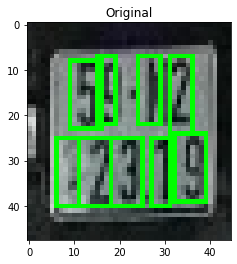

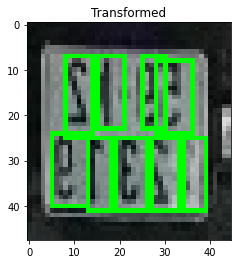

In [ ]:
plt.figure()
plt.title("Original")
showBoxes(img,boxes)
hFlipGenerator = transformer(hFlip)
hFlipImg,hFlipBoxes = hFlipGenerator.transform(img,boxes)
plt.figure()
plt.title("Transformed")
showBoxes(hFlipImg,hFlipBoxes,'hflip',True)

#### Horizontal and vertical flip

In [ ]:
hvFlip = createTechnique("flip",{"flip":-1})
augmentor.addTransformer(transformer(hvFlip))

Showing the result of applying the transformation.

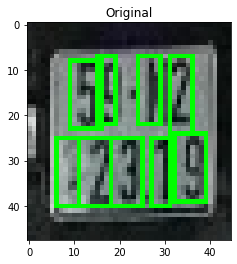

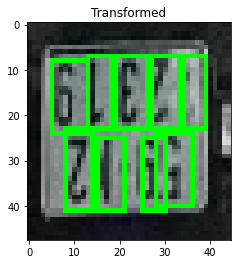

In [ ]:
plt.figure()
plt.title("Original")
showBoxes(img,boxes)
hvFlipGenerator = transformer(hvFlip)
hvFlipImg,hvFlipBoxes = hvFlipGenerator.transform(img,boxes)
plt.figure()
plt.title("Transformed")
showBoxes(hvFlipImg,hvFlipBoxes,'hvflip',True)

#### Rotation:

In [38]:
rotate = createTechnique("rotate", {"angle" : -5})
augmentor.addTransformer(transformer(rotate))

Showing the result of applying the transformation.

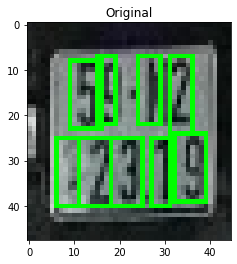

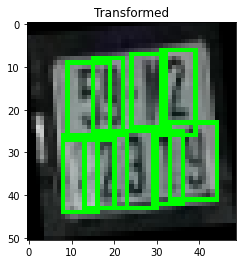

In [37]:
plt.figure()
plt.title("Original")
showBoxes(img,boxes)
rotateGenerator = transformer(rotate)
rotateImg,rotateBoxes = rotateGenerator.transform(img,boxes)
plt.figure()
plt.title("Transformed")
showBoxes(rotateImg,rotateBoxes,'rotate30',True)

#### Average blurring

In [39]:
avgBlur =  createTechnique("average_blurring", {"kernel" : 5})
augmentor.addTransformer(transformer(avgBlur))

Showing the result of applying the transformation.

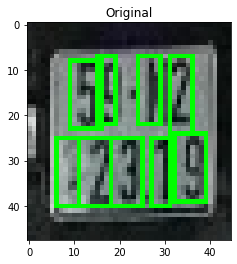

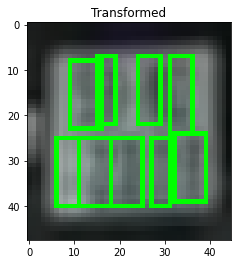

In [ ]:
plt.figure()
plt.title("Original")
showBoxes(img,boxes)
avgBlurGenerator = transformer(avgBlur)
avgBlurImg,avgBlurBoxes = avgBlurGenerator.transform(img,boxes)
plt.figure()
plt.title("Transformed")
showBoxes(avgBlurImg,avgBlurBoxes,'blur',True)

#### Raise Hue

In [41]:
hue = createTechnique("raise_hue", {"power" : 0.9})
augmentor.addTransformer(transformer(hue))

Showing the result of applying the transformation.

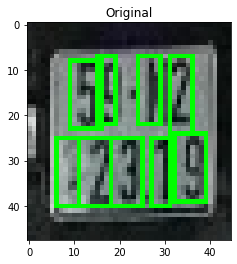

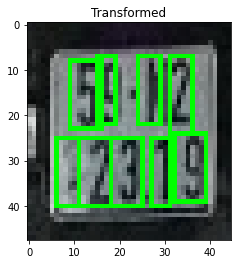

In [ ]:
plt.figure()
plt.title("Original")
showBoxes(img,boxes)
hueGenerator = transformer(hue)
hueImg,hueBoxes = hueGenerator.transform(img,boxes)
plt.figure()
plt.title("Transformed")
showBoxes(hueImg,hueBoxes,'hue',True)

#### None
(to keep also the original image)

In [ ]:
none = createTechnique("none",{})
augmentor.addTransformer(transformer(none))

## Applying the augmentation process

Finally, we apply the augmentation process (this might take some time depending on the number of images of the original dataset and the number of transformations that will be applied). 

In [42]:
augmentor.applyAugmentation()

Finally, we can check the amount of images in the output folder.

In [43]:
print("Number of images in the folder")
!ls -1 augmented_images_yolo/*.jpg | wc -l
print("Number of annotations in the folder")
!ls -1 augmented_images_yolo/*.txt | wc -l

Number of images in the folder
2128
Number of annotations in the folder
2128


In [ ]:
If you are executing this notebook in Colaboratory, you need to download the generated files. To that aim, you can create a zip folder and download it using the following commands. 

SyntaxError: ignored

In [44]:
!zip -r augmented_images_yolo.zip augmented_images_yolo
from google.colab import files
files.download('augmented_images_yolo.zip')

  adding: augmented_images_yolo/ (stored 0%)
  adding: augmented_images_yolo/239_5_frame209.jpg (deflated 14%)
  adding: augmented_images_yolo/79_1_frame283.txt (deflated 70%)
  adding: augmented_images_yolo/290_6_frame467.jpg (deflated 8%)
  adding: augmented_images_yolo/264_0_frame45.txt (deflated 82%)
  adding: augmented_images_yolo/16_0_frame12.txt (deflated 73%)
  adding: augmented_images_yolo/138_5_frame81.jpg (deflated 14%)
  adding: augmented_images_yolo/229_4_frame384.jpg (deflated 8%)
  adding: augmented_images_yolo/203_1_frame53.jpg (deflated 7%)
  adding: augmented_images_yolo/62_0_frame454.jpg (deflated 12%)
  adding: augmented_images_yolo/175_2_frame79.txt (deflated 68%)
  adding: augmented_images_yolo/263_2_frame216.jpg (deflated 8%)
  adding: augmented_images_yolo/164_6_frame96.txt (deflated 77%)
  adding: augmented_images_yolo/203_6_frame53.txt (deflated 74%)
  adding: augmented_images_yolo/112_4_frame310.jpg (deflated 10%)
  adding: augmented_images_yolo/60_3_frame323

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>